In [25]:
# Python 3.8.12

In [1]:

import numpy as np
import pandas as pd
import cv2, os, re
import matplotlib.image
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.models import load_model

2024-03-14 00:58:34.630091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/cv2/../../lib64:
2024-03-14 00:58:34.630174: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
image_input = '../../data_copy/data_test/paris.PNG'
model =  load_model('plane-model.h5')

2024-03-14 00:59:07.180633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/cv2/../../lib64:
2024-03-14 00:59:07.180973: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-14 00:59:07.181087: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UTILISA-O4KTAUM): /proc/driver/nvidia/version does not exist
2024-03-14 00:59:07.189454: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


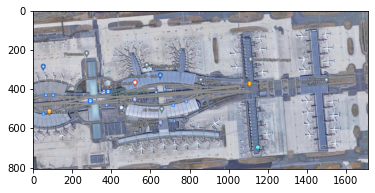

In [5]:
imagei = cv2.imread(image_input)
imagei = cv2.cvtColor(imagei, cv2.COLOR_BGR2RGB)
plt.imshow(imagei)
plt.show()

In [28]:
def to_input(image_input):

    #print(os.path.join(image_input, file))
    image = cv2.imread(image_input)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

def find_roi(image, method="fast"):

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    rects = ss.process()
    roi = []

    for (x,y,w,h) in rects:

        roi.append([x,y,w,h])
        pass

    return roi


def normalise_roi(image,roi_input):

    rois, rois_localisations = [], []
    (H, W) = image.shape[:2]

    for (x,y,w,h) in roi_input:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi_output = image[y:y+h,x:x+w]
        roi_output = cv2.cvtColor(roi_output,cv2.COLOR_BGR2RGB)
        roi_output = cv2.resize(roi_output, (20,20))
        roi_output = np.array(list(map(lambda x : x/255,roi_output)))

        rois.append(roi_output)
        rois_localisations.append((x,y,x+w,y+h))
        pass

    return rois, rois_localisations


def classification_on_roi(rois, model):

    predictions = model.predict(np.array(rois,dtype=np.float32))
    predictions = np.argmax(predictions, axis=1)

    return predictions

def insert_roi_classed_on_image(image, predictions, rois_localisations):

    image_predicted = image.copy()

    for (i,label) in enumerate(predictions):

        if label == 1:
            (startX,startY,endX,endY) = rois_localisations[i]
            cv2.rectangle(image_predicted,(startX,startY),(endX,endY),(0,255,0),2)
        pass

    return image_predicted

def to_output(image_predicted):
    matplotlib.image.imsave('planes_predicted.png', image_predicted)
    pass

In [29]:
image = to_input(image_input)
roi = find_roi(image)
rois, rois_locations = normalise_roi(image, roi)
predictions = classification_on_roi(rois, model)
image_predicted = insert_roi_classed_on_image(image, predictions, rois_locations)
to_output(image_predicted)

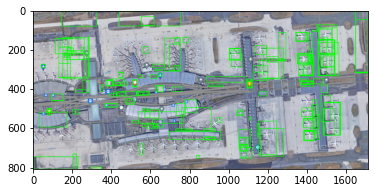

In [30]:
plt.imshow(image_predicted)